# Welcome to Oracle Dev Tour 2025 -- Sail Grand Prix HeatWave Notebook

# Brief example of using HeatWave AutoML and Lakehouse on AWS for predicting BOAT_SPEED of a Catamaran F50 Sail Grand Prix

### In this notebook, we will demonstrate the power of combining Heatwave database platform with a Lakehouse architecture and AutoML for predictive analytics. 
### We will be working with data from the catamaran F-50, which is equipped with IoT sensors capturing various parameters in a data lake of data in the object storage. Our goal is to predict the ## boat speed using an AutoML's machine learning regression model.

### By leveraging Heatwave, we can efficiently run analytics and machine learning workloads directly on lakehouse / object storage data. Heatwave provides unparalleled performance and scalability, enabling us to derive valuable insights and make data-driven decisions. 
### With AutoML, we can automate the process of model selection and hyperparameter tuning, accelerating our time-to-value and delivering accurate predictions.

### By predicting the boat speed accurately, we can optimize performance, enhance decision-making, and improve overall operational efficiency. 
### The insights gained from this predictive model can be applied to various use cases, such as racing 
### strategy optimization, fuel efficiency, and real-time performance monitoring.

### Let's begin by importing the necessary libraries and exploring the Lakehouse data.(Not covered in this Notebook)
###  Follow the instructions provided in the live lab  "Win the race with MySQL HeatWave Lakehouse":
#### https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/view-workshop?wid=3836&clear=RR,180&session=117145125842868

### Then, in this Notebook we're going to use HeatWave AutoML to train a regression model and evaluate its performance, to inference and predict the boat speed of a Catamaran F-50, scoring the model with test data and finally explainability of the model and prediction.

### This notebook showcases how Heatwave, combined with a Lakehouse architecture and AutoML, can unlock valuable predictions and enhance decision-making processes, all while leveraging the power one single data platform with HeatWave.
### For more documentation, please make sure to follow the HeatWave AutoML / Lakehouse Livelab for SailGP
#### https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/view-workshop?wid=3836&clear=RR,180&session=117145125842868

### let's start!

### 1. Install all libraries and extensions if not done before

In [1]:
# Uncomment and run the following lines if you need to install the libraries (Execute the following line just the first time)
#!pip install sshtunnel mysql-connector-python pandas matplotlib jsons


### 2. Load all the libraries and extensions needed to run the notebook


In [1]:
import sshtunnel
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import json
import mysql
import random

### 3. Execute the display options and plotting parameters for libraies: pandas, matplotlib, and seaborn.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams['font.size'] = 15


### 4. Defining Variables for ssh connection to database and schema / tables for AutoML

In [9]:
BASTION_IP = '164.152.47.192'
BASTION_USER = 'opc'
DBSYSTEM_IP = '3ee37ac4-80c1-407b-97a4-98e50ed31820.dbsystem.us-east-1.aws.cloud.mysql.com'
DBSYSTEM_USER = 'admin'
DBSYSTEM_PASSWORD = 'G4uss14n!$'
DBSYSTEM_SCHEMA = 'sailgphw'
TABLE_NAME_PIVOT= 'SAILGP_SGP_STRM_PIVOT'
TABLE_NAME_HISTORY = 'SAILGP_SGP_SAIL_HISTORY'
TABLE_NAME_NEWDATA = 'SAILGP_SGP_WINDSPEED_AND_WINDANGLES'
TABLE_NAME_PREDICTION = 'SAILGP_SGP_BOAT_SPEED_PREDICTION'
TARGET_COLUMN = 'BOAT_SPEED'
DEBUG = True

### 5. Set up the SSH tunnel via the Bastion node to the MySQL DBSystem

In [4]:
def get_connection():
    global tunnel, mydbconnection, cursor
    # Set up the SSH tunnel
    try:
        tunnel = sshtunnel.SSHTunnelForwarder(
        (BASTION_IP, 22),
        ssh_username=BASTION_USER,
        ssh_pkey='id_rsa',  # Path to your private SSH key
        remote_bind_address=(DBSYSTEM_IP, 3306))
        tunnel.start()  # Start the SSH tunnel
        # Establish the connection to the MySQL database through the tunnel
        mydbconnection = mysql.connector.connect(
            host="127.0.0.1", 
            port=tunnel.local_bind_port, 
            user=DBSYSTEM_USER, 
            password=DBSYSTEM_PASSWORD, 
            database='mysql', 
            allow_local_infile=True, 
            use_pure=True, 
            autocommit=True
        )
        # Create a cursor for executing queries
        cursor = mydbconnection.cursor()
        print("Connection successful")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None
get_connection()

Connection successful


In [6]:
def run_sql_print(query, table_format=False):
    """Execute a SQL query and print the result in either standard or \G format."""
    cursor.execute(query)
    results = cursor.fetchall()
    
    if table_format:
        # Print each row with detailed formatting (\G style)
        for i, row in enumerate(results, start=1):
            print(f"*************************** {i}. row ***************************")
            for col, value in zip(cursor.description, row):
                print(f"{col[0]}: {value}")
            print()  # Blank line for spacing
    else:
        # Print as a regular table
        col_names = [desc[0] for desc in cursor.description]
        print("\t".join(col_names))
        for row in results:
            print("\t".join(str(value) for value in row))

    return results  # Return the results so they can be used elsewhere

run_sql_print("SELECT version() AS 'Welcome Oracle Dev Tour 2025 MySQL version'", table_format=True)

*************************** 1. row ***************************
Welcome Oracle Dev Tour 2025 MySQL version: 9.2.0-cloud



[('9.2.0-cloud',)]

### 6. Exploring the dataset 

In [7]:
run_sql_print(f"show tables from {DBSYSTEM_SCHEMA}", table_format=False)

Tables_in_sailgphw
SAILGP_SGP_SAIL_HISTORY
SAILGP_SGP_STRM_PIVOT
SAILGP_SGP_WINDSPEED_AND_WINDANGLES


[('SAILGP_SGP_SAIL_HISTORY',),
 ('SAILGP_SGP_STRM_PIVOT',),
 ('SAILGP_SGP_WINDSPEED_AND_WINDANGLES',)]

In [10]:
run_sql_print(f"DESC {DBSYSTEM_SCHEMA}.{TABLE_NAME_PIVOT}", table_format=False)

Field	Type	Null	Key	Default	Extra
TIME_GRP	int	NO		None	
B_NAME	varchar(9)	NO		None	
LENGTH_RH_BOW_MM	float	YES		None	
LENGTH_RH_P_MM	float	YES		None	
LENGTH_RH_S_MM	float	YES		None	
TWA_SGP_DEG	float	YES		None	
TWS_MHU_TM_KM_H_1	float	YES		None	
BDE_BOAT_RACE_STATUS_UNK	float	YES		None	
HEADING_DEG	float	YES		None	
DB_STOW_STATE_P_UNK	float	YES		None	
DB_STOW_STATE_S_UNK	float	YES		None	
ANGLE_PILOT_P_R_DEG	float	YES		None	
ANGLE_DB_CANT_P_DEG	float	YES		None	
ANGLE_RUDDER_OFFSET_DEG	float	YES		None	
ANGLE_RUDDER_DEG	float	YES		None	
ANGLE_FLAP_4_TWIST_DEG	float	YES		None	
ANGLE_FLAP_1_TWIST_DEG	float	YES		None	
ANGLE_CA1_DEG	float	YES		None	
ANGLE_JORAL_P_L_DEG	float	YES		None	
ANGLE_CA5_DEG	float	YES		None	
ANGLE_CA6_DEG	float	YES		None	
ANGLE_FLAP_2_TWIST_DEG	float	YES		None	
ANGLE_RUD_RAKE_P_DEG	float	YES		None	
ANGLE_DB_RAKE_P_TARG_DEG	float	YES		None	
ANGLE_DB_CANT_S_DEG	float	YES		None	
ANGLE_RUD_AVG_DEG	float	YES		None	
ANGLE_RUD_DIFF_TACK_DEG	float	YES		None	
ANGLE_CA1_TARG_D

[('TIME_GRP', 'int', 'NO', '', None, ''),
 ('B_NAME', 'varchar(9)', 'NO', '', None, ''),
 ('LENGTH_RH_BOW_MM', 'float', 'YES', '', None, ''),
 ('LENGTH_RH_P_MM', 'float', 'YES', '', None, ''),
 ('LENGTH_RH_S_MM', 'float', 'YES', '', None, ''),
 ('TWA_SGP_DEG', 'float', 'YES', '', None, ''),
 ('TWS_MHU_TM_KM_H_1', 'float', 'YES', '', None, ''),
 ('BDE_BOAT_RACE_STATUS_UNK', 'float', 'YES', '', None, ''),
 ('HEADING_DEG', 'float', 'YES', '', None, ''),
 ('DB_STOW_STATE_P_UNK', 'float', 'YES', '', None, ''),
 ('DB_STOW_STATE_S_UNK', 'float', 'YES', '', None, ''),
 ('ANGLE_PILOT_P_R_DEG', 'float', 'YES', '', None, ''),
 ('ANGLE_DB_CANT_P_DEG', 'float', 'YES', '', None, ''),
 ('ANGLE_RUDDER_OFFSET_DEG', 'float', 'YES', '', None, ''),
 ('ANGLE_RUDDER_DEG', 'float', 'YES', '', None, ''),
 ('ANGLE_FLAP_4_TWIST_DEG', 'float', 'YES', '', None, ''),
 ('ANGLE_FLAP_1_TWIST_DEG', 'float', 'YES', '', None, ''),
 ('ANGLE_CA1_DEG', 'float', 'YES', '', None, ''),
 ('ANGLE_JORAL_P_L_DEG', 'float', 'YES',

In [11]:
run_sql_print(f"SELECT * FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_PIVOT} LIMIT 10", table_format=False)


TIME_GRP	B_NAME	LENGTH_RH_BOW_MM	LENGTH_RH_P_MM	LENGTH_RH_S_MM	TWA_SGP_DEG	TWS_MHU_TM_KM_H_1	BDE_BOAT_RACE_STATUS_UNK	HEADING_DEG	DB_STOW_STATE_P_UNK	DB_STOW_STATE_S_UNK	ANGLE_PILOT_P_R_DEG	ANGLE_DB_CANT_P_DEG	ANGLE_RUDDER_OFFSET_DEG	ANGLE_RUDDER_DEG	ANGLE_FLAP_4_TWIST_DEG	ANGLE_FLAP_1_TWIST_DEG	ANGLE_CA1_DEG	ANGLE_JORAL_P_L_DEG	ANGLE_CA5_DEG	ANGLE_CA6_DEG	ANGLE_FLAP_2_TWIST_DEG	ANGLE_RUD_RAKE_P_DEG	ANGLE_DB_RAKE_P_TARG_DEG	ANGLE_DB_CANT_S_DEG	ANGLE_RUD_AVG_DEG	ANGLE_RUD_DIFF_TACK_DEG	ANGLE_CA1_TARG_DEG	ANGLE_RUD_DIFF_DEG	ANGLE_CA4_TARG_DEG	ANGLE_FLAP_3_TWIST_DEG	ANGLE_JORAL_S_R_DEG	ANGLE_DB_RAKE_S_DEG	ANGLE_CA5_TARG_DEG	ANGLE_DB_RAKE_S_TARG_DEG	ANGLE_WING_TWIST_ABS_DEG	ANGLE_CA2_DEG	ANGLE_WING_TWIST_DEG	ANGLE_RUD_RAKE_P_TARG_DEG	ANGLE_CA6_TARG_DEG	ANGLE_DB_RAKE_LIM_DEG	ANGLE_CA4_DEG	ANGLE_JORAL_S_L_DEG	ANGLE_PILOT_P_L_DEG	ANGLE_PILOT_S_R_DEG	ANGLE_RUD_RAKE_S_TARG_DEG	ANGLE_FLAP_5_TWIST_DEG	ANGLE_JORAL_P_R_DEG	ANGLE_DB_RAKE_S_AOA_DEG	ANGLE_CA2_TARG_DEG	ANGLE_WING_ROT_DEG	ANGLE_PILOT_S_

[(-10,
  'GBR',
  0.858053,
  0.659169,
  -0.860429,
  56.3056,
  53.2377,
  1.0,
  101.386,
  5.0,
  1.0,
  131.267,
  -10.3658,
  68.872,
  70.1006,
  8.58076,
  7.57783,
  -30.81,
  126.696,
  -16.8477,
  -10.768,
  0.0,
  4.70536,
  4.31223,
  6.27179,
  1.57728,
  6.22058,
  -30.9994,
  6.22058,
  -23.3384,
  0.0,
  315.137,
  6.98163,
  -15.42,
  6.99988,
  24.9587,
  0.0,
  24.9571,
  4.74352,
  -6.88391,
  -2.03238,
  -23.3685,
  231.486,
  283.276,
  155.92,
  -1.49997,
  8.79854,
  202.283,
  6.78763,
  0.0,
  35.7755,
  45.0007,
  4.96436,
  -1.53711,
  4.38443,
  0.0,
  0.0,
  '#NAME?',
  1.0,
  27.869,
  'Yes',
  1.0,
  'N',
  'X',
  0.0,
  32.2775,
  -64.853,
  0.0),
 (0,
  'AUS',
  0.47861,
  0.60337,
  0.540289,
  95.9671,
  57.8532,
  2.0,
  51.8051,
  5.0,
  1.0,
  265.39,
  -10.2369,
  68.872,
  67.1439,
  5.85737,
  4.81269,
  -21.7603,
  325.442,
  -2.86645,
  5.31666,
  0.0,
  4.03815,
  2.42165,
  6.23988,
  2.02482,
  3.61193,
  -21.5197,
  3.61193,
  -16.55,
  

In [12]:
run_sql_print(f"SELECT * FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY} LIMIT 10", table_format=False)


PK	WIND_ANGLE	WIND_SPEED	BOAT_SPEED
1	172.442	24.4076	12.0558
2	175.145	13.9128	11.8481
3	95.6105	15.8607	45.7213
4	79.7853	20.4085	49.3743
5	58.2215	24.3168	42.447
6	117.427	4.33629	8.09798
7	88.472	26.7429	50.4675
8	115.993	10.2954	32.2869
9	67.2931	2.45577	3.84986
10	163.869	25.0948	20.0654


[(1, 172.442, 24.4076, 12.0558),
 (2, 175.145, 13.9128, 11.8481),
 (3, 95.6105, 15.8607, 45.7213),
 (4, 79.7853, 20.4085, 49.3743),
 (5, 58.2215, 24.3168, 42.447),
 (6, 117.427, 4.33629, 8.09798),
 (7, 88.472, 26.7429, 50.4675),
 (8, 115.993, 10.2954, 32.2869),
 (9, 67.2931, 2.45577, 3.84986),
 (10, 163.869, 25.0948, 20.0654)]

### 7. Splitting the history data into TRAIN and TEST dataset 

In [13]:

def split_train_test(train_size=0.7):
    # Retrieve all data from the table
    cursor.execute(f"SELECT PK FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}")  
    data = [row[0] for row in cursor.fetchall()]  # Extract only primary keys
    # Shuffle the data randomly to avoid bias
    random.shuffle(data)
    # Calculate the split index based on the train_size ratio
    split_index = int(len(data) * train_size)
    # Split the data into training and testing sets
    train_ids = data[:split_index]
    test_ids = data[split_index:]
    # Create training table
    cursor.execute(f"DROP TABLE IF EXISTS {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}_train")
    cursor.execute(f"CREATE TABLE {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}_train AS SELECT * FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY} WHERE PK IN (%s)""" % ','.join(map(str, train_ids)))
    # Create testing table
    cursor.execute(f"DROP TABLE IF EXISTS {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}_test")
    cursor.execute(f"CREATE TABLE {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}_test AS SELECT * FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY} WHERE PK IN (%s)""" % ','.join(map(str, test_ids)))
    ########## Print the sizes of the training and testing sets
    query = f"SELECT count(*) FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}"
    cursor.execute(query)
    # Fetch the result
    result = cursor.fetchone()  # Assuming it returns a single value
    # Print the result with the formatted message
    print(f"History set size: {result[0]}")
    query = f"SELECT count(*) FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}_train"
    cursor.execute(query)
    # Fetch the result
    result = cursor.fetchone()  # Assuming it returns a single value
    # Print the result with the formatted message
    print(f"Testing set size: {result[0]}")
    query = f"SELECT count(*) FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}_test"
    cursor.execute(query)
    # Fetch the result
    result = cursor.fetchone()  # Assuming it returns a single value
    # Print the result with the formatted message
    print(f"Testing set size: {result[0]}")
    print("Splitting complete")

split_train_test()

History set size: 2000
Testing set size: 1400
Testing set size: 600
Splitting complete


### 8. Invoking HeatWave AutoML sys.ML_TRAIN and sys.ML_MODEL_LOAD for training a regression model to predict the boat_speed of the Catamaran F-50

In [14]:
def model_training():
    # First query to train the model
    query_train = f"""
    CALL sys.ML_TRAIN(
        '{DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}_train',
        '{TARGET_COLUMN}', 
        JSON_OBJECT('task', 'regression', 'exclude_column_list', JSON_ARRAY('PK')),
        @boat_speed_model_xgbregression
    );
    """
    cursor.execute(query_train)
    # Second query to load the trained model
    query_load = f"""CALL sys.ML_MODEL_LOAD(@boat_speed_model_xgbregression, NULL);"""
    cursor.execute(query_load)
# Calling the function
model_training()


### 9. Within MySQL performance schema, you can find the RAPID tables to monitorig the execution progress of the AutoML procedures

In [15]:
# Execute and print the result of the query
query = f"SELECT * FROM performance_schema.rpd_query_stats"
run_sql_print(query, table_format=False)

QUERY_ID	STATEMENT_ID	CONNECTION_ID	QUERY_TEXT	QEXEC_TEXT	QKRN_TEXT	QEP_TEXT	INTERNAL_OFFLOAD_FAIL_TEXT	EXTERNAL_OFFLOAD_FAIL_TEXT	OFFLOAD_FAIL_QUERY_SUBSTR_START	OFFLOAD_FAIL_QUERY_SUBSTR_LEN	EXPORT_FILE_PREFIX
8	456917	4323	ML_LOAD_TABLE	{"status": "Completed", "completedSteps": [], "completionPercentage": 100, "totalRunTime": "6.27 Seconds", "startTime": "02/06/2025, 18:32:24:210852 UTC", "progressItems": [], "details": {}}	{}	{}			0	0	None
10	458319	4323	ML_TRAIN	{"status": "Completed", "completedSteps": ["Initialization", "Preprocessing", "Algorithm Selection", "Row Sampling", "Column Selection", "Hyperparameter Optimization", "Model Generation", "Prediction Explainer", "Model Explainer"], "completionPercentage": 100, "totalRunTime": "101.91 Seconds", "startTime": "02/06/2025, 18:32:30:975407 UTC", "progressItems": [{"type": "Initialization", "status": "Completed", "lastUpdated": "02/06/2025, 18:32:31:344139 UTC", "completionPercentage": 100}, {"type": "Preprocessing", "status": "

[(8,
  456917,
  4323,
  'ML_LOAD_TABLE',
  '{"status": "Completed", "completedSteps": [], "completionPercentage": 100, "totalRunTime": "6.27 Seconds", "startTime": "02/06/2025, 18:32:24:210852 UTC", "progressItems": [], "details": {}}',
  '{}',
  '{}',
  '',
  '',
  0,
  0,
  None),
 (10,
  458319,
  4323,
  'ML_TRAIN',
  '{"status": "Completed", "completedSteps": ["Initialization", "Preprocessing", "Algorithm Selection", "Row Sampling", "Column Selection", "Hyperparameter Optimization", "Model Generation", "Prediction Explainer", "Model Explainer"], "completionPercentage": 100, "totalRunTime": "101.91 Seconds", "startTime": "02/06/2025, 18:32:30:975407 UTC", "progressItems": [{"type": "Initialization", "status": "Completed", "lastUpdated": "02/06/2025, 18:32:31:344139 UTC", "completionPercentage": 100}, {"type": "Preprocessing", "status": "Completed", "lastUpdated": "02/06/2025, 18:32:31:513868 UTC", "completionPercentage": 100}, {"type": "Algorithm Selection", "status": "Completed",

### 10. Scoring the Model (AutoML Regression XGBRegressor) with Metric R2, for other Metrics look the documentation:
### https://blogs.oracle.com/mysql/post/using-various-scoring-metrics-to-evaluate-mysql-heatwave-ml-models
### https://dev.mysql.com/doc/heatwave/en/mys-hwaml-model-quality.html



In [16]:
def score_model(metric='r2'):
    # Define the model scoring query
    query_score = f"""CALL sys.ML_SCORE(
        '{DBSYSTEM_SCHEMA}.{TABLE_NAME_HISTORY}_test',
        '{TARGET_COLUMN}',@boat_speed_model_xgbregression ,'{metric}', @score,NULL);"""
    cursor.execute(query_score)
    # Define the query to retrieve the score
    query_get_score = """SELECT @score;"""
    return run_sql_print(query_get_score, table_format=False)
# Example usage
print(score_model())

@score
0.9990740418434143
[(0.9990740418434143,)]


2025-02-06 15:21:45,452| ERROR   | Socket exception: Connection reset by peer (54)


### 11. Exploring the MODEL_CATALOG  

In [151]:
# Define the DESC query
query_desc = f"DESC ML_SCHEMA_admin.MODEL_CATALOG;"
run_sql_print(query_desc, table_format=False)


Field	Type	Null	Key	Default	Extra
model_id	bigint	NO	PRI	None	auto_increment
model_handle	varchar(255)	NO	UNI	None	
model_type	varchar(64)	YES		None	
task	varchar(64)	YES		None	
model_object	longtext	YES		None	
model_owner	varchar(64)	YES		None	
build_timestamp	bigint	YES		None	
target_column_name	varchar(64)	YES		None	
train_table_name	varchar(255)	YES		None	
column_names	json	YES		None	
model_explanation	json	YES		None	
last_accessed	int	YES		None	
model_object_size	bigint	YES		None	
notes	varchar(8192)	YES		None	
model_metadata	json	YES		None	


[('model_id', 'bigint', 'NO', 'PRI', None, 'auto_increment'),
 ('model_handle', 'varchar(255)', 'NO', 'UNI', None, ''),
 ('model_type', 'varchar(64)', 'YES', '', None, ''),
 ('task', 'varchar(64)', 'YES', '', None, ''),
 ('model_object', 'longtext', 'YES', '', None, ''),
 ('model_owner', 'varchar(64)', 'YES', '', None, ''),
 ('build_timestamp', 'bigint', 'YES', '', None, ''),
 ('target_column_name', 'varchar(64)', 'YES', '', None, ''),
 ('train_table_name', 'varchar(255)', 'YES', '', None, ''),
 ('column_names', 'json', 'YES', '', None, ''),
 ('model_explanation', 'json', 'YES', '', None, ''),
 ('last_accessed', 'int', 'YES', '', None, ''),
 ('model_object_size', 'bigint', 'YES', '', None, ''),
 ('notes', 'varchar(8192)', 'YES', '', None, ''),
 ('model_metadata', 'json', 'YES', '', None, '')]

In [152]:
# Define the SELECT query
query_model_catalog = f"""
SELECT model_id, model_type, column_names, target_column_name 
FROM ML_SCHEMA_admin.MODEL_CATALOG;
"""

# Execute the query and print the result
run_sql_print(query_model_catalog, table_format=False)


model_id	model_type	column_names	target_column_name
13	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
14	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
15	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
16	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
17	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
18	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
19	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
20	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
21	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED
22	XGBRegressor	["WIND_ANGLE", "WIND_SPEED"]	BOAT_SPEED


[(13, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (14, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (15, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (16, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (17, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (18, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (19, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (20, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (21, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED'),
 (22, 'XGBRegressor', '["WIND_ANGLE", "WIND_SPEED"]', 'BOAT_SPEED')]

In [153]:
# Define the SELECT query
query_model_explanation = f"""
SELECT model_explanation 
FROM ML_SCHEMA_{DBSYSTEM_USER}.MODEL_CATALOG 
WHERE model_handle = @boat_speed_model_xgbregression;
"""

# Execute the query and print the result
run_sql_print(query_model_explanation, table_format=False)


model_explanation
{"permutation_importance": {"WIND_ANGLE": 1.1038, "WIND_SPEED": 0.9304}}


[('{"permutation_importance": {"WIND_ANGLE": 1.1038, "WIND_SPEED": 0.9304}}',)]

### 12. Showing model Explanations 

model_explanation
{"permutation_importance": {"WIND_ANGLE": 1.1038, "WIND_SPEED": 0.9304}}


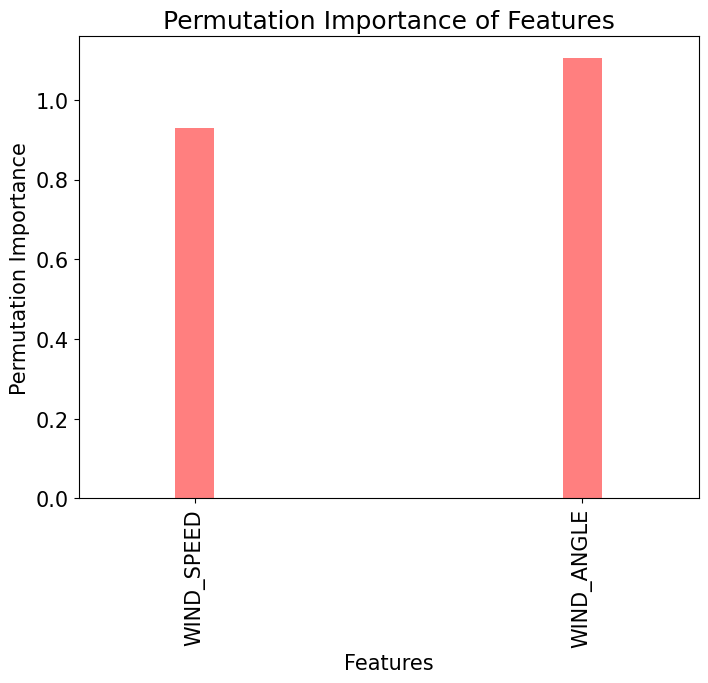

In [154]:

def show_model_explanations():
    # Define the query
    query_model_explanation = f"""SELECT model_explanation
    FROM ML_SCHEMA_{DBSYSTEM_USER}.MODEL_CATALOG WHERE model_handle = @boat_speed_model_xgbregression;"""
    # Execute the query and get the result using run_sql_print
    result = run_sql_print(query_model_explanation, table_format=False)
    # Assuming result is a list of tuples, we retrieve the first row and first column
    model_explanation_json = result[0][0]
    # Convert the JSON stored in the database into a Python dictionary
    explanation_dict = json.loads(model_explanation_json)
    # Extract the permutation importance
    permutation_importance = explanation_dict.get('permutation_importance', [])
    # Plotting the permutation importance
    plt.figure(figsize=(8, 6))  # Width x Height
    importance_series = pd.Series(permutation_importance).sort_values(ascending=True)
    importance_series.plot(kind='bar', color='r', alpha=0.5, width=0.1)
    plt.xlabel('Features')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importance of Features')
    plt.show()
show_model_explanations()

### 13. Generate Predictions (sys.ML_PREDICT_TABLE heatwave function)

In [155]:
def generate_predict_table():
    # First query to drop the table if it exists
    drop_table_query = f"DROP TABLE IF EXISTS {DBSYSTEM_SCHEMA}.{TABLE_NAME_PREDICTION}"
    cursor.execute(drop_table_query)  # Using cursor.execute() for dropping the table

    # Second query to call the prediction stored procedure
    predict_table_query = f"""
    CALL sys.ML_PREDICT_TABLE(
        '{DBSYSTEM_SCHEMA}.{TABLE_NAME_NEWDATA}', 
        @boat_speed_model_xgbregression,
        '{DBSYSTEM_SCHEMA}.{TABLE_NAME_PREDICTION}',
        NULL
    );
    """
    cursor.execute(predict_table_query)  # Using cursor.execute() for calling the procedure
    print("Prediction table generated")

# Call the function to generate the prediction table
generate_predict_table()


Prediction table generated


In [156]:
def describe_prediction_table():
    # Define the DESC query
    desc_query = f"DESC {DBSYSTEM_SCHEMA}.{TABLE_NAME_PREDICTION}"
    
    # Execute the query and print the result using run_sql_print
    run_sql_print(desc_query, table_format=False)

# Call the function to describe the prediction table
describe_prediction_table()


Field	Type	Null	Key	Default	Extra
PK	int	NO	PRI	None	
WIND_ANGLE	float	YES		None	
WIND_SPEED	float	YES		None	
Prediction	float	NO		None	
ml_results	text	NO		None	


In [157]:
def preview_prediction_table():
    # Define the SELECT query to retrieve the first 10 rows
    select_query = f"SELECT * FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_PREDICTION} LIMIT 10"
    
    # Execute the query and print the result using run_sql_print
    run_sql_print(select_query, table_format=False)

# Call the function to preview the prediction table
preview_prediction_table()


PK	WIND_ANGLE	WIND_SPEED	Prediction	ml_results
1	1.0	5.0	0.497164	{"predictions": {"BOAT_SPEED": 0.4971639811992645}}
2	2.0	5.0	0.503477	{"predictions": {"BOAT_SPEED": 0.5034767389297485}}
3	3.0	5.0	0.464352	{"predictions": {"BOAT_SPEED": 0.4643520712852478}}
4	4.0	5.0	0.489824	{"predictions": {"BOAT_SPEED": 0.4898236095905304}}
5	5.0	5.0	0.521214	{"predictions": {"BOAT_SPEED": 0.5212138891220093}}
6	6.0	5.0	0.802305	{"predictions": {"BOAT_SPEED": 0.8023052215576172}}
7	7.0	5.0	0.815262	{"predictions": {"BOAT_SPEED": 0.8152619004249573}}
8	8.0	5.0	0.808883	{"predictions": {"BOAT_SPEED": 0.8088827133178711}}
9	9.0	5.0	0.923688	{"predictions": {"BOAT_SPEED": 0.9236882925033569}}
10	10.0	5.0	0.917556	{"predictions": {"BOAT_SPEED": 0.9175560474395752}}


In [158]:
def query_boat_speed_prediction(wind_angle, wind_speed):
    # Define the SELECT query with variables for WIND_ANGLE and WIND_SPEED
    select_query = f"SELECT * FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_PREDICTION} WHERE WIND_ANGLE={wind_angle} AND WIND_SPEED>={wind_speed}"
    
    # Execute the query and print the result using run_sql_print
    run_sql_print(select_query, table_format=False)

# Call the function with the desired values for WIND_ANGLE and WIND_SPEED
query_boat_speed_prediction(45, 10)


PK	WIND_ANGLE	WIND_SPEED	Prediction	ml_results
405	45.0	10.0	16.3512	{"predictions": {"BOAT_SPEED": 16.35122299194336}}
765	45.0	15.0	24.5536	{"predictions": {"BOAT_SPEED": 24.553598403930664}}
1125	45.0	20.0	30.5085	{"predictions": {"BOAT_SPEED": 30.508520126342773}}
1485	45.0	25.0	32.0568	{"predictions": {"BOAT_SPEED": 32.056819915771484}}


### 14. Generate Predictions (ML_PREDICT_ROW)

### 15. Plot the Wind_angle versus Boat_Speed

WIND_ANGLE	ml_results
1.0	{"predictions": {"BOAT_SPEED": 0.4971639811992645}}
2.0	{"predictions": {"BOAT_SPEED": 0.5034767389297485}}
3.0	{"predictions": {"BOAT_SPEED": 0.4643520712852478}}
4.0	{"predictions": {"BOAT_SPEED": 0.4898236095905304}}
5.0	{"predictions": {"BOAT_SPEED": 0.5212138891220093}}
6.0	{"predictions": {"BOAT_SPEED": 0.8023052215576172}}
7.0	{"predictions": {"BOAT_SPEED": 0.8152619004249573}}
8.0	{"predictions": {"BOAT_SPEED": 0.8088827133178711}}
9.0	{"predictions": {"BOAT_SPEED": 0.9236882925033569}}
10.0	{"predictions": {"BOAT_SPEED": 0.9175560474395752}}
11.0	{"predictions": {"BOAT_SPEED": 1.0578702688217163}}
12.0	{"predictions": {"BOAT_SPEED": 1.3517383337020874}}
13.0	{"predictions": {"BOAT_SPEED": 1.4013073444366455}}
14.0	{"predictions": {"BOAT_SPEED": 1.5264124870300293}}
15.0	{"predictions": {"BOAT_SPEED": 1.5675561428070068}}
16.0	{"predictions": {"BOAT_SPEED": 1.7243499755859375}}
17.0	{"predictions": {"BOAT_SPEED": 1.9219560623168945}}
18.0	{"predictions

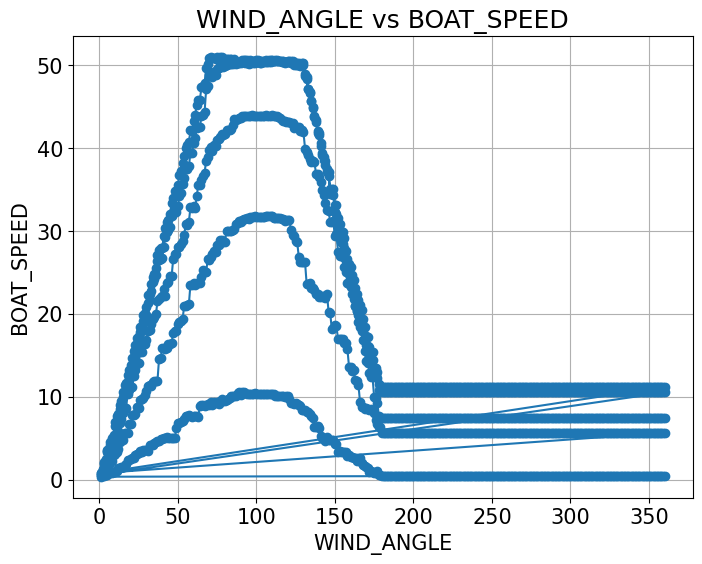

In [159]:
def wind_angle_versus_boatspeed():
    # Define the SQL query
    sql_query = f"SELECT WIND_ANGLE, ml_results FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_PREDICTION}"
    
    # Execute the query using run_sql_print
    result = run_sql_print(sql_query, table_format=False)

    # Ensure all result rows are fetched (if cursor still holds any data)
    cursor.fetchall()  # Clear the cursor before moving forward

    # Convert the result into a DataFrame (assuming result is a list of tuples)
    df = pd.DataFrame(result, columns=['WIND_ANGLE', 'ml_results'])

    # Extract the boat speed from the JSON field and add it as a new column to the DataFrame
    df['BOAT_SPEED'] = df['ml_results'].apply(lambda x: json.loads(x)['predictions']['BOAT_SPEED'])

    # Plot WIND_ANGLE vs BOAT_SPEED
    plt.figure(figsize=(8, 6))  # Width x Height
    plt.plot(df['WIND_ANGLE'], df['BOAT_SPEED'], marker='o', linestyle='-')
    plt.xlabel('WIND_ANGLE')
    plt.ylabel('BOAT_SPEED')
    plt.title('WIND_ANGLE vs BOAT_SPEED')
    plt.grid(True)
    plt.show()

# Call the function to generate the plot
wind_angle_versus_boatspeed()

*************************** 1. row ***************************
WIND_SPEED: 5.0
ml_results: {"predictions": {"BOAT_SPEED": 0.4971639811992645}}

*************************** 2. row ***************************
WIND_SPEED: 5.0
ml_results: {"predictions": {"BOAT_SPEED": 0.5034767389297485}}

*************************** 3. row ***************************
WIND_SPEED: 5.0
ml_results: {"predictions": {"BOAT_SPEED": 0.4643520712852478}}

*************************** 4. row ***************************
WIND_SPEED: 5.0
ml_results: {"predictions": {"BOAT_SPEED": 0.4898236095905304}}

*************************** 5. row ***************************
WIND_SPEED: 5.0
ml_results: {"predictions": {"BOAT_SPEED": 0.5212138891220093}}

*************************** 6. row ***************************
WIND_SPEED: 5.0
ml_results: {"predictions": {"BOAT_SPEED": 0.8023052215576172}}

*************************** 7. row ***************************
WIND_SPEED: 5.0
ml_results: {"predictions": {"BOAT_SPEED": 0.815261900424

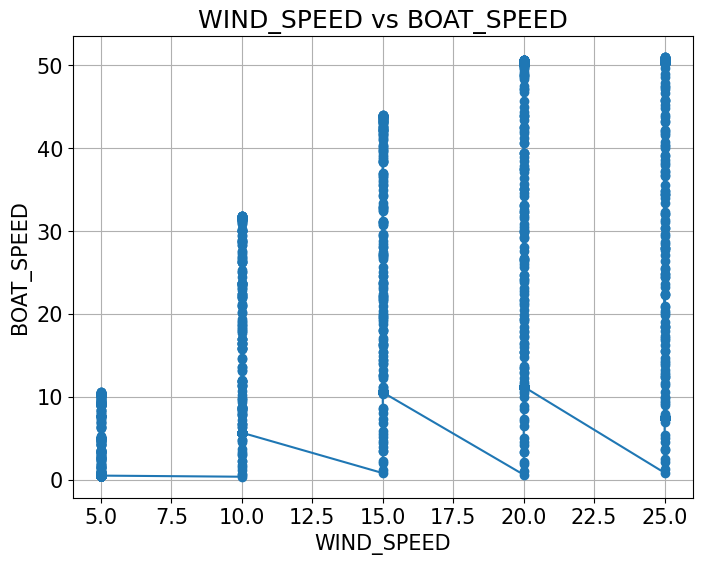

In [160]:
def wind_speed_versus_boatspeed():
    # Define the SQL query to retrieve WIND_SPEED and ml_results
    sql_query = f"SELECT WIND_SPEED, ml_results FROM {DBSYSTEM_SCHEMA}.{TABLE_NAME_PREDICTION}"
    
    # Execute the query and print the result using run_sql_print
    run_sql_print(sql_query, table_format=True)

    # Since run_sql_print does not return data, we will need to retrieve it and process
    df = pd.read_sql(sql_query, mydbconnection)  # Read the data into a DataFrame from the database

    # Extract the boat speed from the JSON field and add it as a new column to the DataFrame
    df['BOAT_SPEED'] = df['ml_results'].apply(lambda x: json.loads(x)['predictions']['BOAT_SPEED'])

    # Plot WIND_SPEED vs BOAT_SPEED
    plt.figure(figsize=(8, 6))  # Width x Height
    plt.plot(df['WIND_SPEED'], df['BOAT_SPEED'], marker='o', linestyle='-')
    plt.xlabel('WIND_SPEED')
    plt.ylabel('BOAT_SPEED')
    plt.title('WIND_SPEED vs BOAT_SPEED')
    plt.grid(True)
    plt.show()

# Call the function to plot WIND_SPEED vs BOAT_SPEED
wind_speed_versus_boatspeed()

In [17]:
def close_connection():
    # Close the cursor if it's open
    if cursor is not None:
        cursor.close()
        print("Cursor closed.")

    # Close the connection if it's open
    if mydbconnection is not None:
        mydbconnection.close()
        print("Connection closed.")
